<a href="https://colab.research.google.com/github/neisyo-korea/chobo-s-tear/blob/main/bearing_failure_data_based_LSTM_AE_d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [3]:
# set random seed
seed(10)
tf.random.set_seed(10)

In [4]:
# load data 
sensor_data = pd.read_csv('/content/train_data.csv', index_col=0)
new_header = sensor_data.iloc[0] #grab the first row for the header
sensor_data = sensor_data[1:] #take the data less the header row
sensor_data.columns = new_header #set the header row as the df header
sensor_data.head()

Time (min),X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52
0,0.248889998,3702.300049,4502.700195,9.416999817,26.99600029,42.18299866,2705.199951,75.17299652,120.4000015,0.336109996,...,54.05899811,24.80400085,63.26900101,21.95000076,40.18799973,39.46099854,47,47.59400177,41.38399887,18.90500069
1,0.249039993,3666.199951,4526,9.268199921,26.70999908,42.33200073,2705.5,74.41100311,120.4100037,0.336760014,...,53.78099823,24.79000092,62.17100143,22.23900032,40.10800171,43.70999908,46.12799835,47.50799942,41.65800095,18.97599983
2,0.250340015,3673.300049,4501.299805,9.421199799,26.84199905,42.36000061,2705.300049,75.125,120.4100037,0.337390006,...,54.07500076,24.66900063,61.58499908,22.19099998,40.02999878,39.47999954,44.12099838,47.61199951,41.72100067,16.56200027
3,0.25108999,3657.800049,4497.799805,9.379199982,26.52799988,41.98199844,2707.300049,73.99199677,120.3799973,0.33664,...,54.11700058,24.59499931,61.56100082,21.95899963,40.12099838,32.84799957,45.85800171,47.45899963,40.83599854,20.09399986
4,0.245629996,3698,4537.399902,9.37460041,26.73600006,42.35400009,2705.300049,75.28299713,120.4199982,0.325210005,...,53.90599823,24.45100021,61.38800049,22.27099991,39.5379982,36.68199921,45.75299835,47.45800018,41.72700119,18.32999992


In [5]:
#split data 80/20 with last 20% as the test set
last_20percent = round(len(sensor_data) - len(sensor_data)*.2)
train = sensor_data.iloc[ :last_20percent, :]
test = sensor_data.iloc[last_20percent: ,:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (800, 52)
Test dataset shape: (200, 52)


In [10]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"

In [11]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (800, 1, 52)
Test data shape: (200, 1, 52)


In [12]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 52)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             4416      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [14]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
76/76 [==============================] - 6s 13ms/step - loss: 0.4540 - val_loss: 0.4114
Epoch 2/100
76/76 [==============================] - 0s 4ms/step - loss: 0.2930 - val_loss: 0.1740
Epoch 3/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1400 - val_loss: 0.1582
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1364 - val_loss: 0.1580
Epoch 5/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1362 - val_loss: 0.1572
Epoch 6/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1360 - val_loss: 0.1583
Epoch 7/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1360 - val_loss: 0.1578
Epoch 8/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1360 - val_loss: 0.1582
Epoch 9/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1359 - val_loss: 0.1566
Epoch 10/100
76/76 [==============================] - 0s 4ms/step - loss: 0.1359 - val_loss: 0.1576
Epoch 11

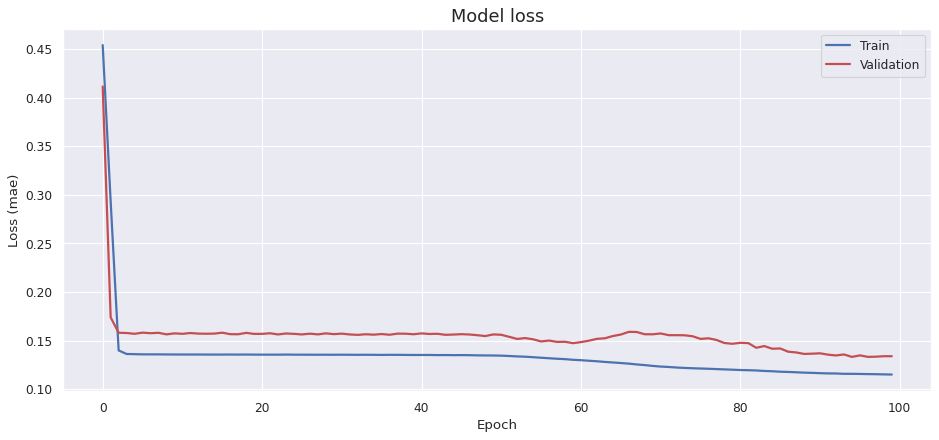

In [15]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

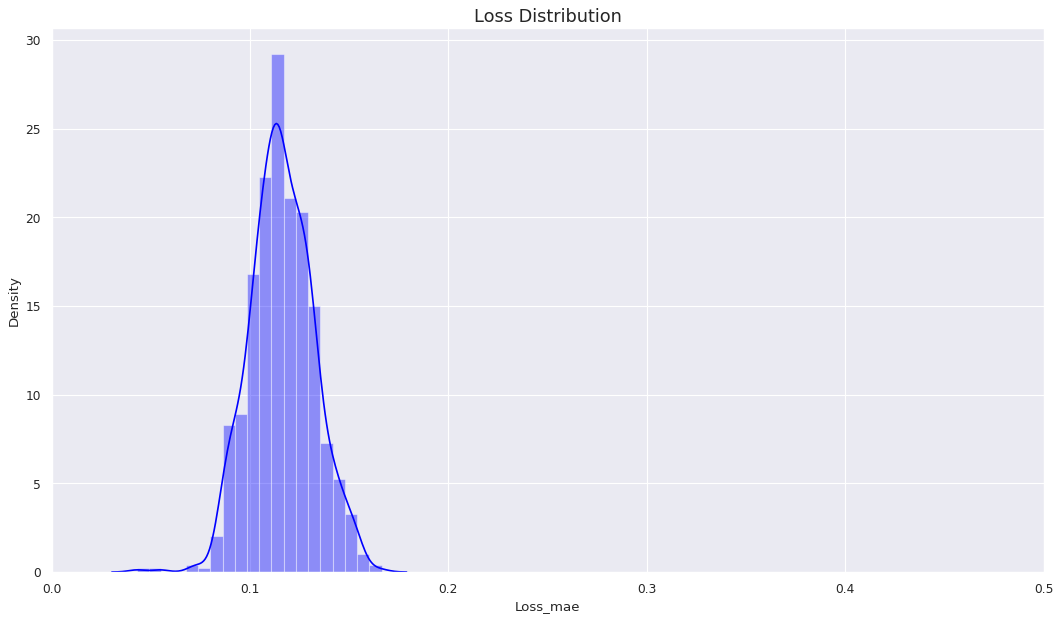

In [16]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [32]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.2 # threshold 의 맥스값은 describe으로 찾아보니 0.19정도 인데 이거 코드 수정하면 될듯. 일단은 0.2로 해놈. 
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()
# 출력이 모두 false인 것을 보니 학습이 매우 잘되었음. 추가적으로 인코딩 할때 뉴런개수 조정하면 될듯. 

,Loss_mae,Threshold,Anomaly
800,0.132864,0.2,False
801,0.162182,0.2,False
802,0.123209,0.2,False
803,0.144339,0.2,False
804,0.135594,0.2,False


In [33]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

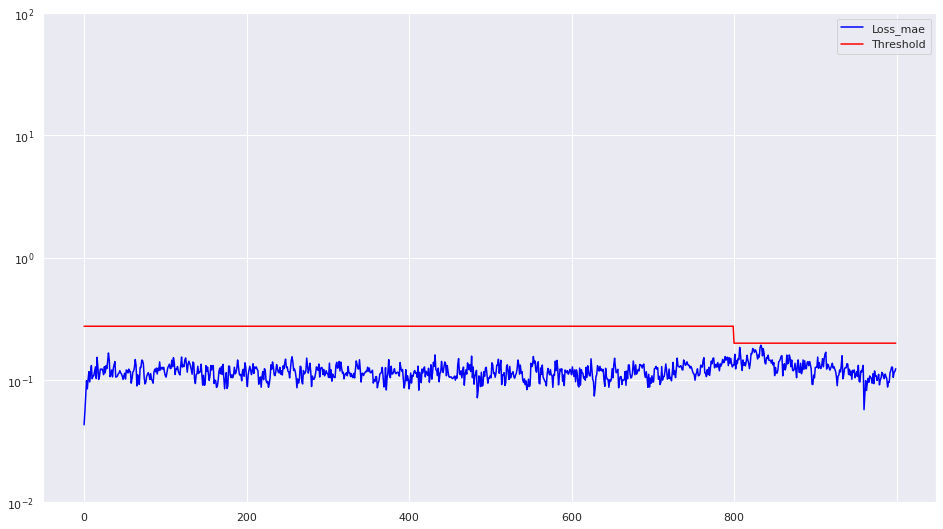

In [34]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [35]:
# save all model information, including weights, in h5 format
model.save("bearing-sensor-anomaly-detection.h5")
print("Model saved")

Model saved
